In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


* **CustomerID**: Müşteri ID
* **Surname**: Müşteri Soyadı
* **CreditScore**: Müşterinin kredi skoru
* **Geography**: Müşterinin Ülkesi
* **Gender**: Müşterinin cinsiyeti.
* **Age**: Müşterinin yaşı.
* **Tenure**: Müşterinin bankayla ilişkisinin yıl cinsinden süresini gösterir.
* **Balance**: Müşterinin hesabındaki bakiye.
* **NumOfProducts**: Müşterinin kullandığı banka ürünü sayısı (örneğin, cari hesap, tasarruf hesabı, kredi kartı)
* **HasCrCard**: Müşterinin kredi kartına sahip olup olmadığını gösterir.(1 = evet, 0 = hayır).
* **IsActiveMember**: Müşterinin hesabını aktif olarak kullanıp kullanmadığını gösterir.(1=aktif, 0=aktif değil)
* **EstimatedSalary**: Müşterinin yıllık tahimini kazancı.
* **Exited**: Bankanın müşteriyi kaybedip kaybetmediği gösterir. (1=kaybetti, 0=kaybetmedi) 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.3f' % x)
pd.set_option('display.width', 500)

In [4]:
df = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")

In [5]:
def check_df(dataframe, head=5):
    print("############################################")
    print(dataframe.shape)
    print("############################################")
    print(dataframe.dtypes)
    print("############################################")
    print(dataframe.nunique())
    print("############################################")
    print(dataframe.head(head))
    print("############################################")
    print(dataframe.tail(head))
    print("############################################")
    print(dataframe.isnull().sum())
    
check_df(df)

############################################
(10000, 14)
############################################
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
############################################
RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64
############################################
   RowNumber  CustomerId   Surname  CreditScore Geogr

In [6]:
def grab_col_names(dataframe, cat_th=11, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes =='O']
    num_but_cat = [col for col in dataframe.columns if ((dataframe[col].dtypes !='O') & (dataframe[col].nunique() <= cat_th))]
    cat_but_car = [col for col in dataframe.columns if ((dataframe[col].dtypes == 'O') & (dataframe[col].nunique() > car_th))]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    return cat_cols, cat_but_car, num_cols
cat_cols, cat_but_car, num_cols = grab_col_names(df)

print(cat_cols)
print(cat_but_car)
print(num_cols)

['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
['Surname']
['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary']


In [7]:
num_cols = [col for col in num_cols if col not in ['RowNumber', 'CustomerId']]

print(cat_cols)
print(cat_but_car)
print(num_cols)

['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
['Surname']
['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


           Geography  Ratio
Geography                  
France          5014 50.140
Germany         2509 25.090
Spain           2477 24.770


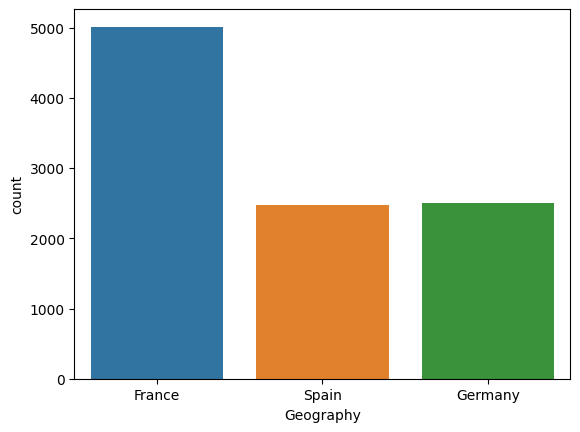

        Gender  Ratio
Gender               
Male      5457 54.570
Female    4543 45.430


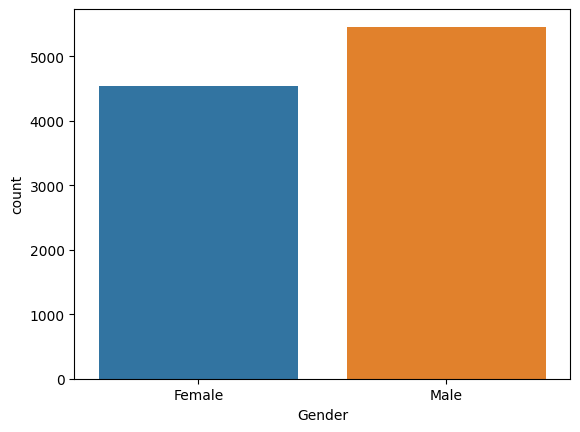

        Tenure  Ratio
Tenure               
2         1048 10.480
1         1035 10.350
7         1028 10.280
8         1025 10.250
5         1012 10.120
3         1009 10.090
4          989  9.890
9          984  9.840
6          967  9.670
10         490  4.900
0          413  4.130


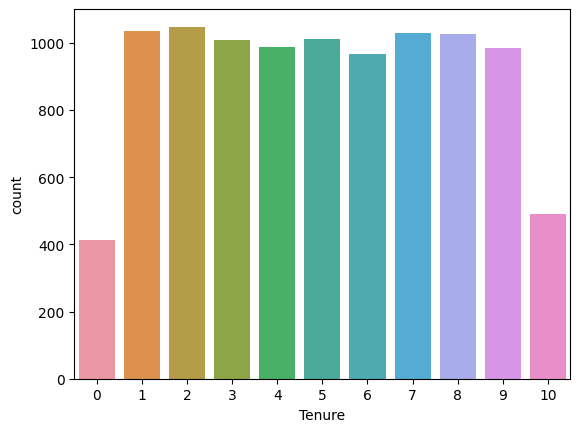

               NumOfProducts  Ratio
NumOfProducts                      
1                       5084 50.840
2                       4590 45.900
3                        266  2.660
4                         60  0.600


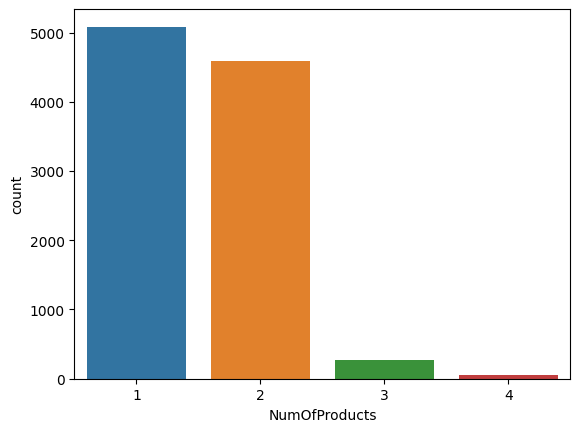

           HasCrCard  Ratio
HasCrCard                  
1               7055 70.550
0               2945 29.450


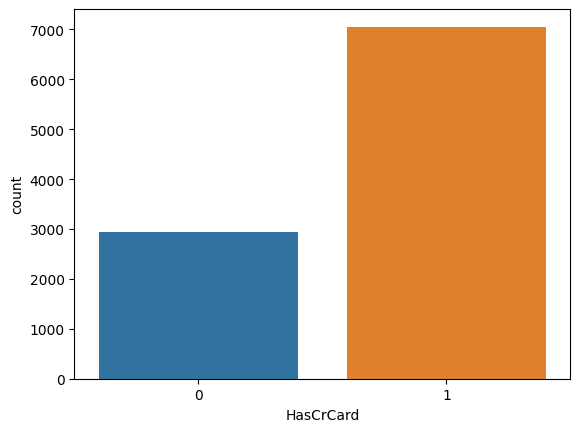

                IsActiveMember  Ratio
IsActiveMember                       
1                         5151 51.510
0                         4849 48.490


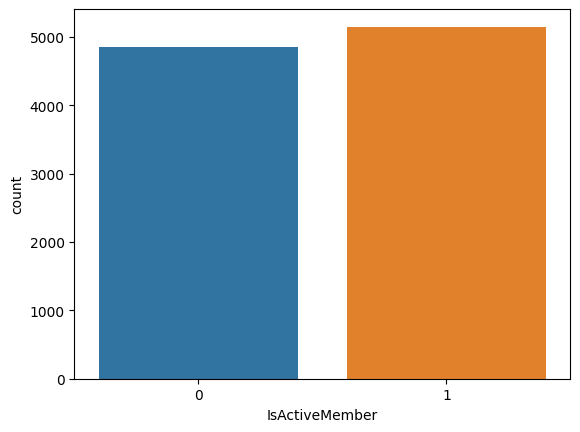

        Exited  Ratio
Exited               
0         7963 79.630
1         2037 20.370


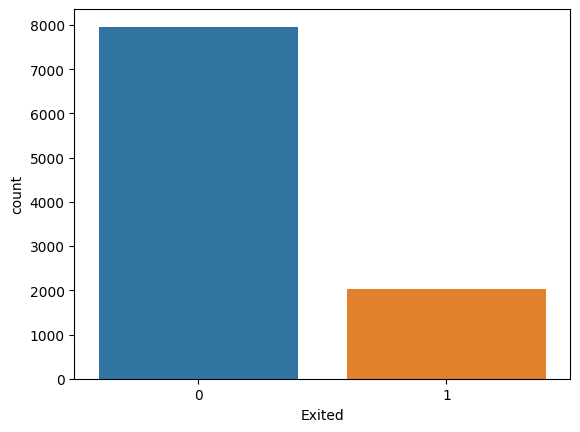

In [8]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe[col_name])}))
    
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
for col in cat_cols:
    cat_summary(df, col, True)

count   10000.000
mean      650.529
std        96.653
min       350.000
5%        489.000
10%       521.000
20%       566.000
30%       598.700
40%       627.000
50%       652.000
60%       678.000
70%       704.000
80%       735.000
90%       778.000
95%       812.000
99%       850.000
100%      850.000
max       850.000
Name: CreditScore, dtype: float64


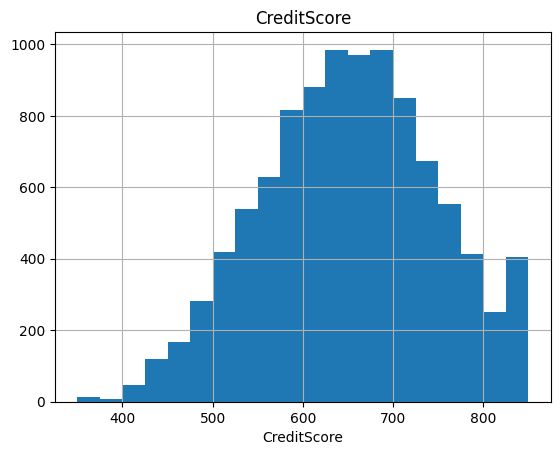

count   10000.000
mean       38.922
std        10.488
min        18.000
5%         25.000
10%        27.000
20%        31.000
30%        33.000
40%        35.000
50%        37.000
60%        40.000
70%        42.000
80%        46.000
90%        53.000
95%        60.000
99%        72.000
100%       92.000
max        92.000
Name: Age, dtype: float64


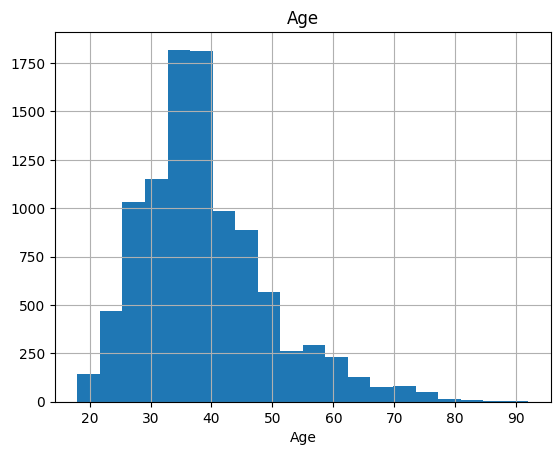

count    10000.000
mean     76485.889
std      62397.405
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%      73080.908
50%      97198.540
60%     110138.926
70%     122029.870
80%     133710.358
90%     149244.792
95%     162711.669
99%     185967.985
100%    250898.090
max     250898.090
Name: Balance, dtype: float64


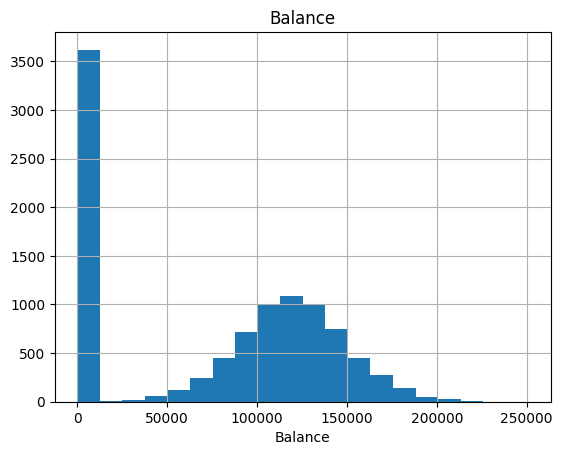

count    10000.000
mean    100090.240
std      57510.493
min         11.580
5%        9851.819
10%      20273.580
20%      41050.736
30%      60736.079
40%      80238.340
50%     100193.915
60%     119710.038
70%     139432.236
80%     159836.726
90%     179674.704
95%     190155.375
99%     198069.734
100%    199992.480
max     199992.480
Name: EstimatedSalary, dtype: float64


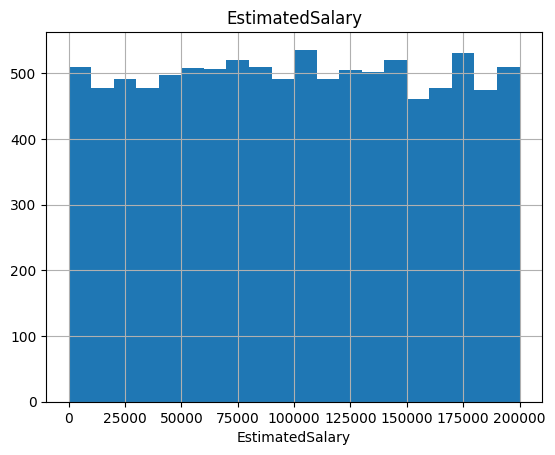

In [9]:
def num_summary(dataframe, num_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
    print(dataframe[num_col].describe(quantiles).T)
    
    if plot:
        dataframe[num_col].hist(bins=20)
        plt.xlabel(num_col)
        plt.title(num_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, True)

        CreditScore
Exited             
0           651.853
1           645.351





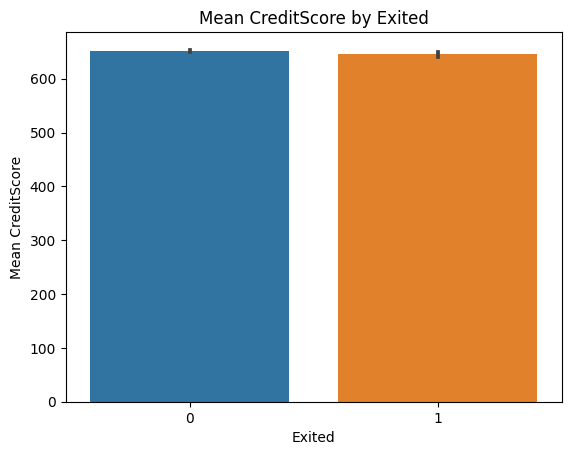

          Age
Exited       
0      37.408
1      44.838





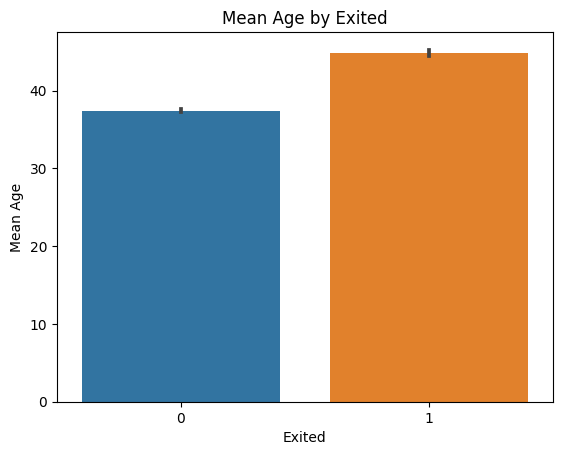

         Balance
Exited          
0      72745.297
1      91108.539





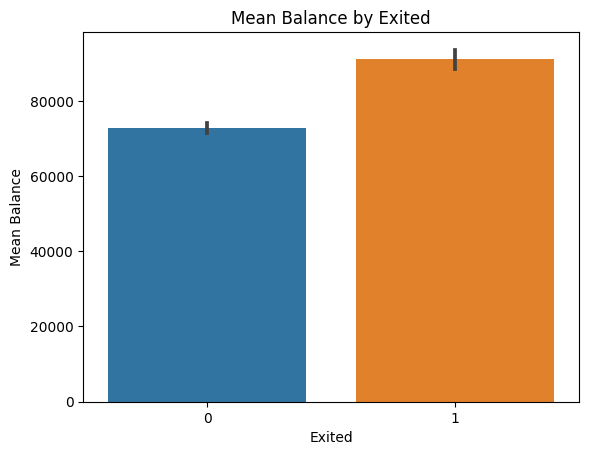

        EstimatedSalary
Exited                 
0             99738.392
1            101465.678





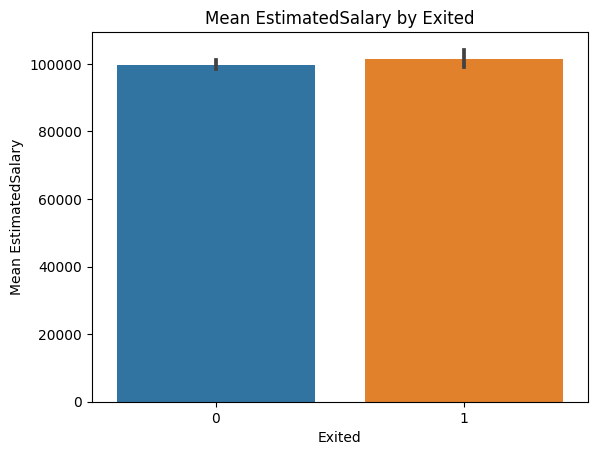

In [10]:
def target_analysis_num(dataframe, target, num_col, plot=False):
    print(dataframe.groupby(target).agg({num_col: "mean"}), end="\n\n\n\n")     
    
    if plot==True:
        sns.barplot(x=target, y=num_col, data=dataframe)
        plt.xlabel(target)
        plt.ylabel(f'Mean {col}')
        plt.title(f'Mean {col} by {target}')
        plt.show()

for col in num_cols:
    target_analysis_num(df, "Exited", col, True)

                  Exited
Geography Exited        
France    0         4204
          1          810
Germany   0         1695
          1          814
Spain     0         2064
          1          413





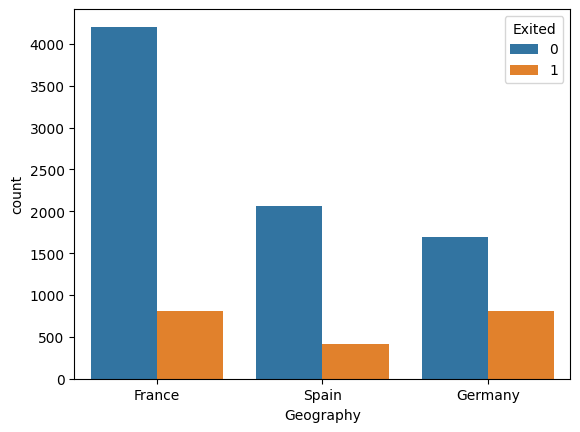

               Exited
Gender Exited        
Female 0         3404
       1         1139
Male   0         4559
       1          898





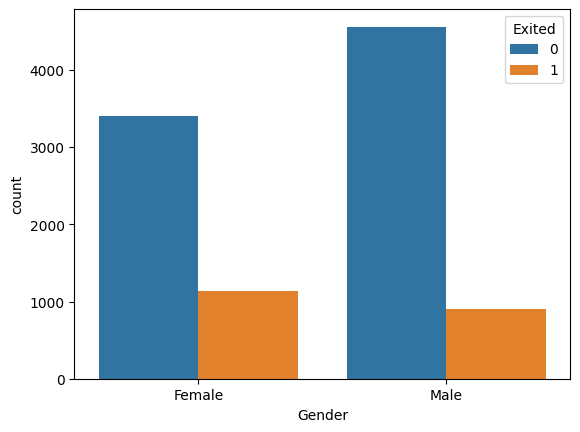

               Exited
Tenure Exited        
0      0          318
       1           95
1      0          803
       1          232
2      0          847
       1          201
3      0          796
       1          213
4      0          786
       1          203
5      0          803
       1          209
6      0          771
       1          196
7      0          851
       1          177
8      0          828
       1          197
9      0          771
       1          213
10     0          389
       1          101





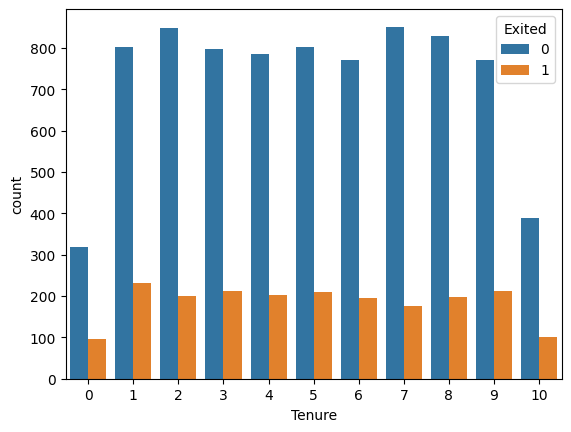

                      Exited
NumOfProducts Exited        
1             0         3675
              1         1409
2             0         4242
              1          348
3             0           46
              1          220
4             1           60





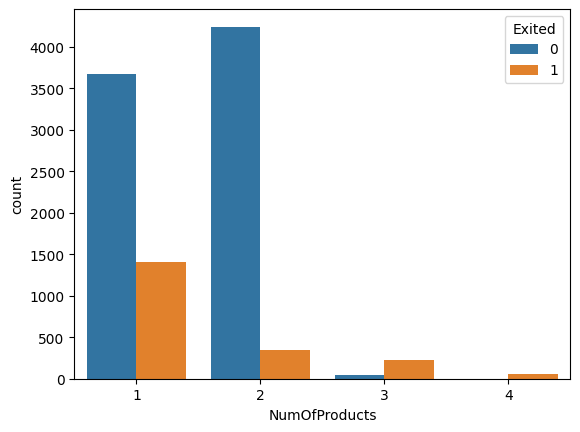

                  Exited
HasCrCard Exited        
0         0         2332
          1          613
1         0         5631
          1         1424





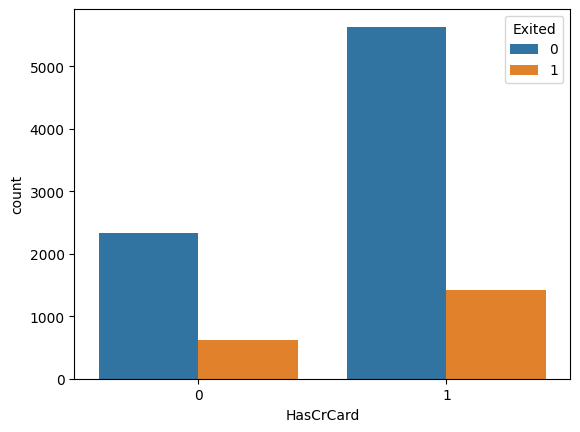

                       Exited
IsActiveMember Exited        
0              0         3547
               1         1302
1              0         4416
               1          735





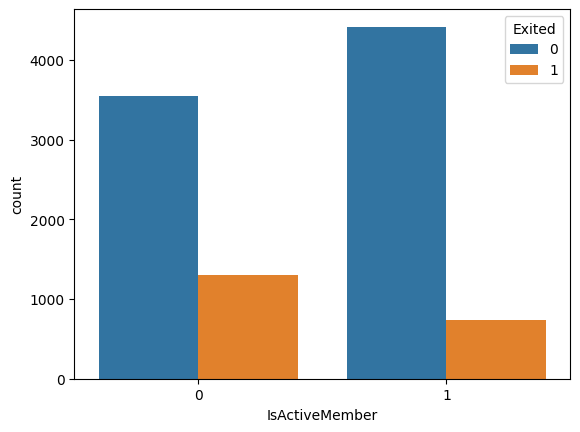

               Exited
Exited Exited        
0      0         7963
1      1         2037





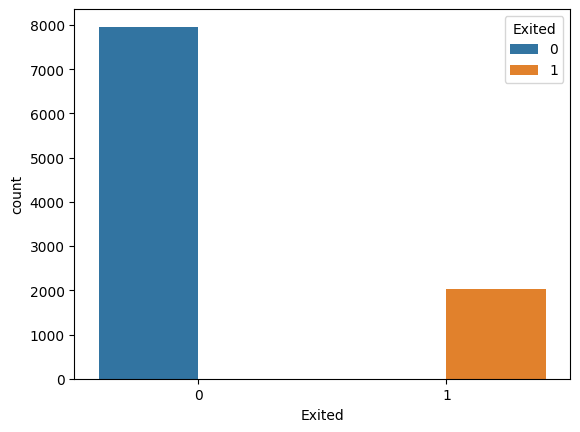

In [11]:
def target_analysis_cat(dataframe, target, cat_col, plot=False):
    print(dataframe.groupby([cat_col, target]).agg({target: "count"}), end="\n\n\n\n")
    
    if plot==True:
        sns.countplot(x=cat_col, hue="Exited", data=df)
        plt.show()

for col in cat_cols:
    target_analysis_cat(df, "Exited", col, True)

# **Feature Engineering**

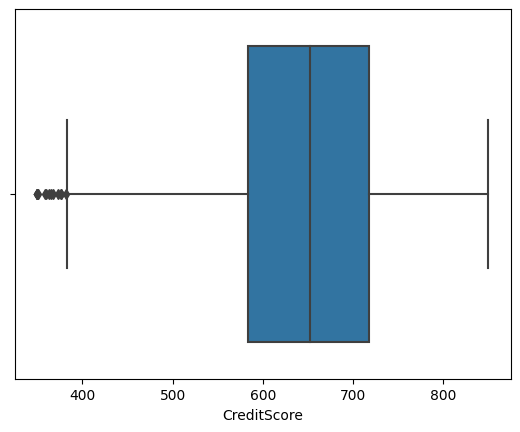

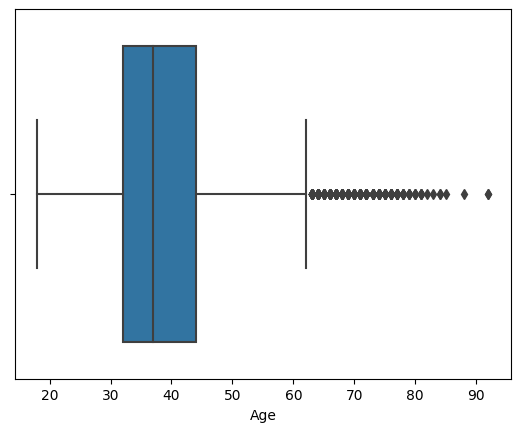

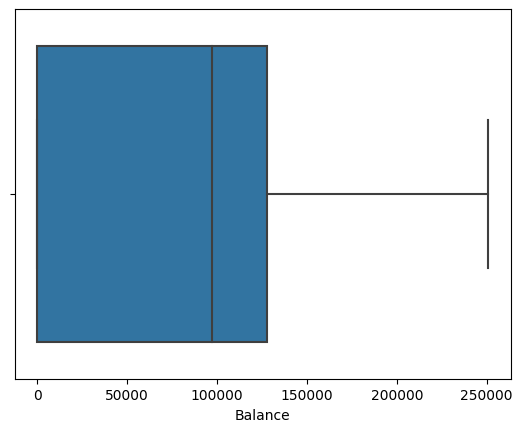

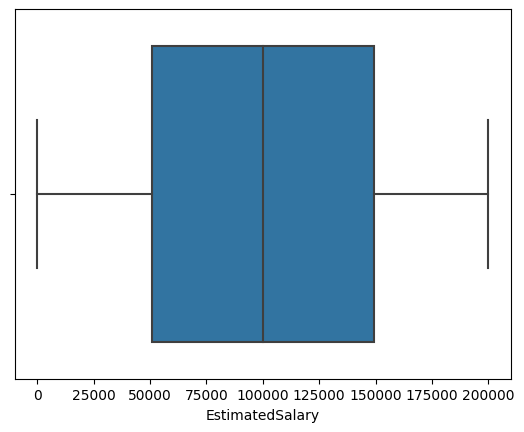

In [12]:
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.show()

In [13]:
def outlier_threshold(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col].quantile(q1)
    quartile3 = dataframe[col].quantile(q3)
    interguantile = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * interguantile
    upp_limit = quartile3 + 1.5 * interguantile
    return low_limit, upp_limit

In [14]:
def check_outlier(dataframe, col_name):
    low_limit, upp_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col] < low_limit) | (dataframe[col] > upp_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col,":", check_outlier(df, col)) 

CreditScore : True
Age : True
Balance : False
EstimatedSalary : False


In [15]:
def replace_with_thresholds(dataframe, col_name):
    low_limit, upp_limit = outlier_threshold(dataframe, col_name)
    dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
    dataframe.loc[(dataframe[col_name] > upp_limit), col_name] = upp_limit

for col in num_cols:
  replace_with_thresholds(df, col)

In [16]:
def check_outlier(dataframe, col_name):
    low_limit, upp_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col] < low_limit) | (dataframe[col] > upp_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col,":", check_outlier(df, col)) 

CreditScore : False
Age : False
Balance : False
EstimatedSalary : False


In [17]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited'], dtype='object')

In [18]:
#NEW_ACTİVE_CARD:active_card = Banka hesabını aktif kullanıp kredi kartı olan (3607 kişi)
#NEW_ACTİVE_CARD:inactive_card = Banka hesabını aktif kullanmayıp kredi kartı olan (3448 kişi)
#NEW_ACTİVE_CARD:active_notcard = Banka hesabını aktif kullanıp kredi kartı olmayan (1544 kişi)
#NEW_ACTİVE_CARD:inactive_notcard = Banka hesabını aktif kullanmayıp kredi kartı olmayan (1401 kişi)

df.loc[(df["HasCrCard"]==1) & (df["IsActiveMember"]==1), "NEW_ACTİVE_CARD"] = "active_card"
df.loc[(df["HasCrCard"]==1) & (df["IsActiveMember"]==0), "NEW_ACTİVE_CARD"] = "inactive_card"
df.loc[(df["HasCrCard"]==0) & (df["IsActiveMember"]==1), "NEW_ACTİVE_CARD"] = "active_notcard"
df.loc[(df["HasCrCard"]==0) & (df["IsActiveMember"]==0), "NEW_ACTİVE_CARD"] = "inactive_notcard"

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NEW_ACTİVE_CARD
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1,active_card
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,active_notcard
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,inactive_card
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0,inactive_notcard
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0,active_card


In [19]:
#Hesabındaki miktar yıllık maaşından yüksekse yatırımcı olabilir

df.loc[df["Balance"] >= df["EstimatedSalary"], "NEW_IS_INVESTOR"] = "investor"
df.loc[df["Balance"] < df["EstimatedSalary"], "NEW_IS_INVESTOR"] = "not_investor"

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NEW_ACTİVE_CARD,NEW_IS_INVESTOR
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1,active_card,not_investor
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,active_notcard,not_investor
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,inactive_card,investor
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0,inactive_notcard,not_investor
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0,active_card,investor


In [20]:
#yaşa göre

df.loc[(df["Age"] >= 18) & (df["Age"] < 30), "NEW_AGE_CAT"] = "young"
df.loc[(df["Age"] >= 30) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[df["Age"] >= 50, "NEW_AGE_CAT"] = "senior"

df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NEW_ACTİVE_CARD,NEW_IS_INVESTOR,NEW_AGE_CAT
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1,active_card,not_investor,mature
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,active_notcard,not_investor,mature
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,inactive_card,investor,mature
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0,inactive_notcard,not_investor,mature
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0,active_card,investor,mature
5,6,15574012,Chu,645,Spain,Male,44,8,113755.780,2,1,0,149756.710,1,inactive_card,not_investor,mature
6,7,15592531,Bartlett,822,France,Male,50,7,0.000,2,1,1,10062.800,0,active_card,not_investor,senior
7,8,15656148,Obinna,383,Germany,Female,29,4,115046.740,4,1,0,119346.880,1,inactive_card,not_investor,young
8,9,15792365,He,501,France,Male,44,4,142051.070,2,0,1,74940.500,0,active_notcard,investor,mature
9,10,15592389,H?,684,France,Male,27,2,134603.880,1,1,1,71725.730,0,active_card,investor,young


In [21]:
df.loc[(df["Geography"] == "France") & (df["NEW_IS_INVESTOR"] == "investor"), "NEW_IS_GEOGRAPHY_INVESTOR"] = "french_investor"
df.loc[(df["Geography"] == "Spain") & (df["NEW_IS_INVESTOR"] == "investor"), "NEW_IS_GEOGRAPHY_INVESTOR"] = "spanish_investor"
df.loc[(df["Geography"] == "Germany") & (df["NEW_IS_INVESTOR"] == "investor"), "NEW_IS_GEOGRAPHY_INVESTOR"] = "german_investor"
df.loc[(df["Geography"] == "France") & (df["NEW_IS_INVESTOR"] == "not_investor"), "NEW_IS_GEOGRAPHY_INVESTOR"] = "french_not_investor"
df.loc[(df["Geography"] == "Spain") & (df["NEW_IS_INVESTOR"] == "not_investor"), "NEW_IS_GEOGRAPHY_INVESTOR"] = "spanish_not_investor"
df.loc[(df["Geography"] == "Germany") & (df["NEW_IS_INVESTOR"] == "not_investor"), "NEW_IS_GEOGRAPHY_INVESTOR"] = "german_not_investor"

df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NEW_ACTİVE_CARD,NEW_IS_INVESTOR,NEW_AGE_CAT,NEW_IS_GEOGRAPHY_INVESTOR
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1,active_card,not_investor,mature,french_not_investor
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,active_notcard,not_investor,mature,spanish_not_investor
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,inactive_card,investor,mature,french_investor
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0,inactive_notcard,not_investor,mature,french_not_investor
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0,active_card,investor,mature,spanish_investor
5,6,15574012,Chu,645,Spain,Male,44,8,113755.780,2,1,0,149756.710,1,inactive_card,not_investor,mature,spanish_not_investor
6,7,15592531,Bartlett,822,France,Male,50,7,0.000,2,1,1,10062.800,0,active_card,not_investor,senior,french_not_investor
7,8,15656148,Obinna,383,Germany,Female,29,4,115046.740,4,1,0,119346.880,1,inactive_card,not_investor,young,german_not_investor
8,9,15792365,He,501,France,Male,44,4,142051.070,2,0,1,74940.500,0,active_notcard,investor,mature,french_investor
9,10,15592389,H?,684,France,Male,27,2,134603.880,1,1,1,71725.730,0,active_card,investor,young,french_investor


In [22]:
#Kredi notu %5 diliminin altında ise: very_risky
#Kredi notu %5-%30 diliminin arasında ise: risky
#Kredi notu %30-%70 diliminin arasında ise: normal
#Kredi notu %70-%95 diliminin arasında ise: not_risky
#Kredi notu %95 diliminin üstünde ise: very_not_risky


df.loc[(df["CreditScore"] < 489), "NEW_CREDİTSCORE_CAT"] = "very_risky"
df.loc[(df["CreditScore"] >= 489) & (df["CreditScore"] < 599), "NEW_CREDİTSCORE_CAT"] = "risky"
df.loc[(df["CreditScore"] >= 599) & (df["CreditScore"] < 704), "NEW_CREDİTSCORE_CAT"] = "normal"
df.loc[(df["CreditScore"] >= 704) & (df["CreditScore"] < 812), "NEW_CREDİTSCORE_CAT"] = "not_risky"
df.loc[(df["CreditScore"] >= 812), "NEW_CREDİTSCORE_CAT"] = "very_not_risky"

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NEW_ACTİVE_CARD,NEW_IS_INVESTOR,NEW_AGE_CAT,NEW_IS_GEOGRAPHY_INVESTOR,NEW_CREDİTSCORE_CAT
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1,active_card,not_investor,mature,french_not_investor,normal
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,active_notcard,not_investor,mature,spanish_not_investor,normal
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,inactive_card,investor,mature,french_investor,risky
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0,inactive_notcard,not_investor,mature,french_not_investor,normal
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0,active_card,investor,mature,spanish_investor,very_not_risky


In [23]:
investor_size = ['not_investor', 'investor']
age_cat_size = ['young', 'mature', 'senior']
credi_score_size = ['very_risky', 'risky', 'normal', 'not_risky', 'very_not_risky']

enc = OrdinalEncoder(categories=[investor_size, age_cat_size, credi_score_size])
columns_to_encode = ["NEW_IS_INVESTOR", "NEW_AGE_CAT", "NEW_CREDİTSCORE_CAT"]
df[columns_to_encode] = enc.fit_transform(df[columns_to_encode])


In [24]:
fake_cat_cols = [col for col in df.columns if df[col].dtypes =='O']
fake_cat_cols = [col for col in fake_cat_cols if col not in 'Surname' and col not in 'Exited']
fake_cat_cols

['Geography', 'Gender', 'NEW_ACTİVE_CARD', 'NEW_IS_GEOGRAPHY_INVESTOR']

In [25]:
def One_Hot_Encoding(dataframe, col):
    ohe = OneHotEncoder(sparse=False, drop='first')
    encoded_cols = ohe.fit_transform(dataframe[[col]])
    new_columns = [f"{category}" for category in ohe.get_feature_names_out([col])]
    dataframe[new_columns] = encoded_cols
    dataframe.drop([col], axis=1, inplace=True)


for col in fake_cat_cols:
    One_Hot_Encoding(df, col)
    
df.head(10)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NEW_IS_INVESTOR,NEW_AGE_CAT,NEW_CREDİTSCORE_CAT,Geography_Germany,Geography_Spain,Gender_Male,NEW_ACTİVE_CARD_active_notcard,NEW_ACTİVE_CARD_inactive_card,NEW_ACTİVE_CARD_inactive_notcard,NEW_IS_GEOGRAPHY_INVESTOR_french_not_investor,NEW_IS_GEOGRAPHY_INVESTOR_german_investor,NEW_IS_GEOGRAPHY_INVESTOR_german_not_investor,NEW_IS_GEOGRAPHY_INVESTOR_spanish_investor,NEW_IS_GEOGRAPHY_INVESTOR_spanish_not_investor
0,1,15634602,Hargrave,619,42,2,0.000,1,1,1,101348.880,1,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
1,2,15647311,Hill,608,41,1,83807.860,1,0,1,112542.580,0,0.000,1.000,2.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2,3,15619304,Onio,502,42,8,159660.800,3,1,0,113931.570,1,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
3,4,15701354,Boni,699,39,1,0.000,2,0,0,93826.630,0,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000
4,5,15737888,Mitchell,850,43,2,125510.820,1,1,1,79084.100,0,1.000,1.000,4.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
5,6,15574012,Chu,645,44,8,113755.780,2,1,0,149756.710,1,0.000,1.000,2.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
6,7,15592531,Bartlett,822,50,7,0.000,2,1,1,10062.800,0,0.000,2.000,4.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
7,8,15656148,Obinna,383,29,4,115046.740,4,1,0,119346.880,1,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
8,9,15792365,He,501,44,4,142051.070,2,0,1,74940.500,0,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,10,15592389,H?,684,27,2,134603.880,1,1,1,71725.730,0,1.000,0.000,2.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [26]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NEW_IS_INVESTOR,NEW_AGE_CAT,NEW_CREDİTSCORE_CAT,Geography_Germany,Geography_Spain,Gender_Male,NEW_ACTİVE_CARD_active_notcard,NEW_ACTİVE_CARD_inactive_card,NEW_ACTİVE_CARD_inactive_notcard,NEW_IS_GEOGRAPHY_INVESTOR_french_not_investor,NEW_IS_GEOGRAPHY_INVESTOR_german_investor,NEW_IS_GEOGRAPHY_INVESTOR_german_not_investor,NEW_IS_GEOGRAPHY_INVESTOR_spanish_investor,NEW_IS_GEOGRAPHY_INVESTOR_spanish_not_investor
0,1,15634602,Hargrave,-0.327,0.343,2,-1.226,1,1,1,0.022,1,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
1,2,15647311,Hill,-0.441,0.240,1,0.117,1,0,1,0.217,0,0.000,1.000,2.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2,3,15619304,Onio,-1.539,0.343,8,1.333,3,1,0,0.241,1,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
3,4,15701354,Boni,0.502,0.035,1,-1.226,2,0,0,-0.109,0,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000
4,5,15737888,Mitchell,2.066,0.445,2,0.786,1,1,1,-0.365,0,1.000,1.000,4.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
5,6,15574012,Chu,-0.058,0.548,8,0.597,2,1,0,0.864,1,0.000,1.000,2.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
6,7,15592531,Bartlett,1.776,1.163,7,-1.226,2,1,1,-1.565,0,0.000,2.000,4.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
7,8,15656148,Obinna,-2.771,-0.991,4,0.618,4,1,0,0.335,1,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
8,9,15792365,He,-1.549,0.548,4,1.051,2,0,1,-0.437,0,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,10,15592389,H?,0.346,-1.196,2,0.931,1,1,1,-0.493,0,1.000,0.000,2.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


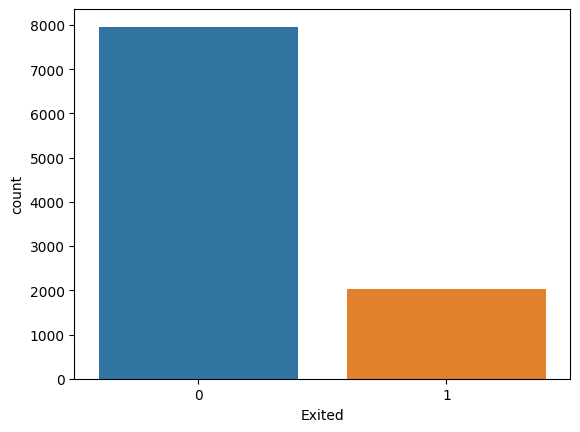

In [27]:
#Doğrudan bu veri setini kullandığımızda recall değeri çok düşük çıkıyor. Yani Exited=1leri 0 olarak tahmin ediyor. Bunun için yeni bir veri seti olduşturdum.

sns.countplot(x=df["Exited"], data=df)
plt.show()

In [28]:

df_exited_0 = df[df["Exited"] == 0]

belirli_miktar = 2500
df_exited_0_4000 = df_exited_0.sample(belirli_miktar, random_state=42)

df_exited_1 = df[df["Exited"] == 1]

common_column = [col for col in df.columns]
dff = pd.merge(df_exited_0_4000, df_exited_1, on=common_column, how='outer')

dff.shape



(4537, 26)

In [29]:
dff.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NEW_IS_INVESTOR,NEW_AGE_CAT,NEW_CREDİTSCORE_CAT,Geography_Germany,Geography_Spain,Gender_Male,NEW_ACTİVE_CARD_active_notcard,NEW_ACTİVE_CARD_inactive_card,NEW_ACTİVE_CARD_inactive_notcard,NEW_IS_GEOGRAPHY_INVESTOR_french_not_investor,NEW_IS_GEOGRAPHY_INVESTOR_german_investor,NEW_IS_GEOGRAPHY_INVESTOR_german_not_investor,NEW_IS_GEOGRAPHY_INVESTOR_spanish_investor,NEW_IS_GEOGRAPHY_INVESTOR_spanish_not_investor
0,1,15634602,Hargrave,-0.327,0.343,2,-1.226,1,1,1,0.022,1,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
1,2,15647311,Hill,-0.441,0.240,1,0.117,1,0,1,0.217,0,0.000,1.000,2.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2,3,15619304,Onio,-1.539,0.343,8,1.333,3,1,0,0.241,1,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
3,6,15574012,Chu,-0.058,0.548,8,0.597,2,1,0,0.864,1,0.000,1.000,2.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
4,8,15656148,Obinna,-2.771,-0.991,4,0.618,4,1,0,0.335,1,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
5,13,15632264,Kay,-1.808,-0.478,10,-1.226,2,1,0,-1.284,0,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000
6,17,15737452,Romeo,0.025,1.984,1,0.899,1,1,0,-1.652,1,1.000,2.000,2.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000
7,20,15568982,Hao,0.781,-1.504,6,-1.226,2,1,1,-0.789,0,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
8,21,15577657,McDonald,0.843,0.240,8,-1.226,2,1,1,1.231,0,0.000,1.000,3.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
9,23,15699309,Gerasimov,-1.456,-0.068,4,-1.226,1,1,0,0.327,1,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000


In [30]:
y = dff["Exited"]
X = dff.drop(["Surname","RowNumber","CustomerId", "Exited"], axis=1)
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.15, random_state=10)

In [31]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]                                          
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

# **Random Forest Model**

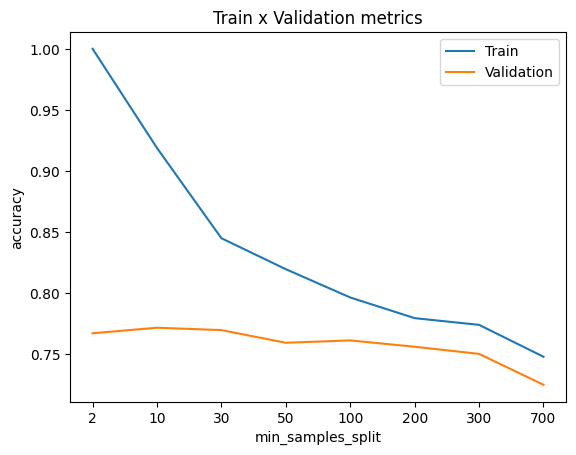

In [32]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = 23).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) 
    predictions_val = model.predict(X_val) 
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

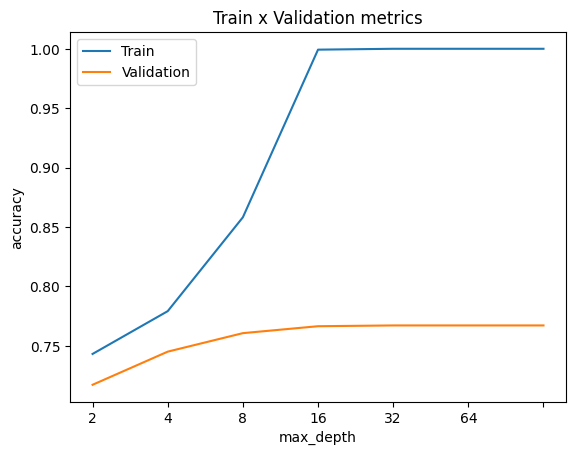

In [33]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = 23).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) 
    predictions_val = model.predict(X_val) 
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

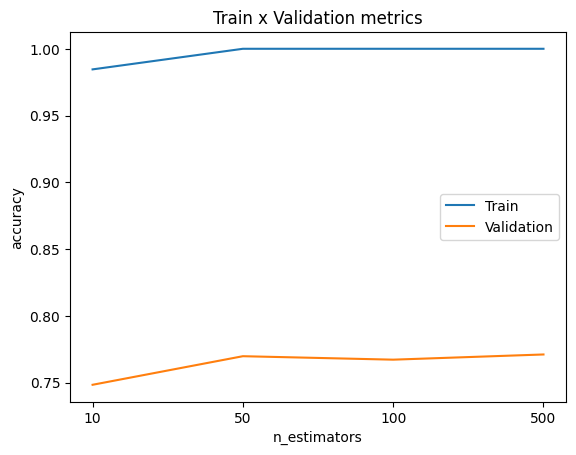

In [34]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = 23).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) 
    predictions_val = model.predict(X_val) 
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [35]:
rf_model = RandomForestClassifier(n_estimators = 500,
                                  max_depth = 16,
                                  min_samples_split = 30,
                                  random_state=23).fit(X_train, y_train)
y_pred_1 = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_1), 2)}")
print(f"Recall: {round(recall_score(y_test,y_pred_1),3)}")
print(f"Precision: {round(precision_score(y_test,y_pred_1), 2)}")
print(f"F1: {round(f1_score(y_test,y_pred_1), 2)}")
print(f"Auc: {round(roc_auc_score(y_test,y_pred_1), 2)}")

Accuracy: 0.81
Recall: 0.72
Precision: 0.81
F1: 0.76
Auc: 0.8


    Value                                         Feature
1   0.281                                             Age
4   0.176                                   NumOfProducts
3   0.091                                         Balance
9   0.074                                     NEW_AGE_CAT
7   0.059                                 EstimatedSalary
0   0.052                                     CreditScore
6   0.049                                  IsActiveMember
11  0.044                               Geography_Germany
2   0.032                                          Tenure
13  0.025                                     Gender_Male
15  0.024                   NEW_ACTİVE_CARD_inactive_card
18  0.018       NEW_IS_GEOGRAPHY_INVESTOR_german_investor
10  0.016                             NEW_CREDİTSCORE_CAT
17  0.011   NEW_IS_GEOGRAPHY_INVESTOR_french_not_investor
16  0.008                NEW_ACTİVE_CARD_inactive_notcard
19  0.007   NEW_IS_GEOGRAPHY_INVESTOR_german_not_investor
8   0.007     

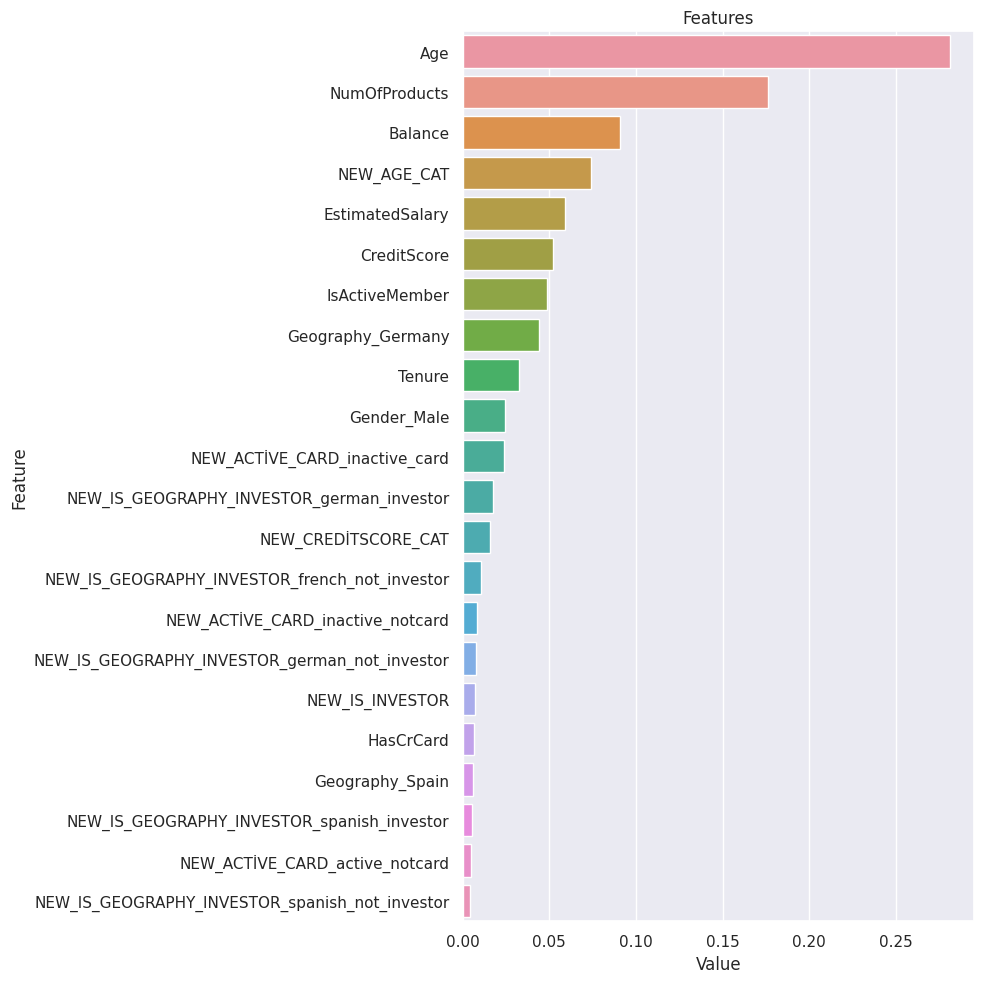

In [36]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

# **Decision Tree Model**

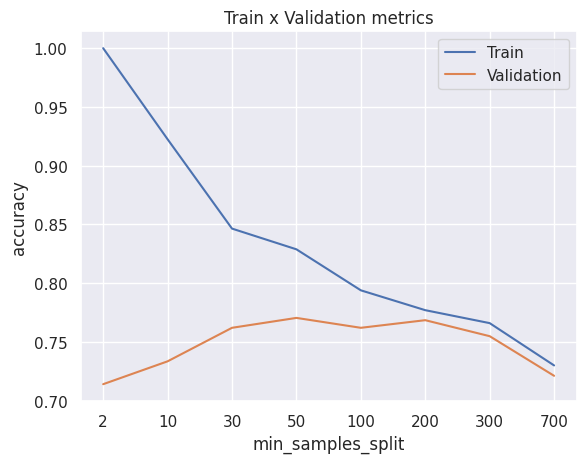

In [37]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = 23).fit(X_train,y_train) 
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

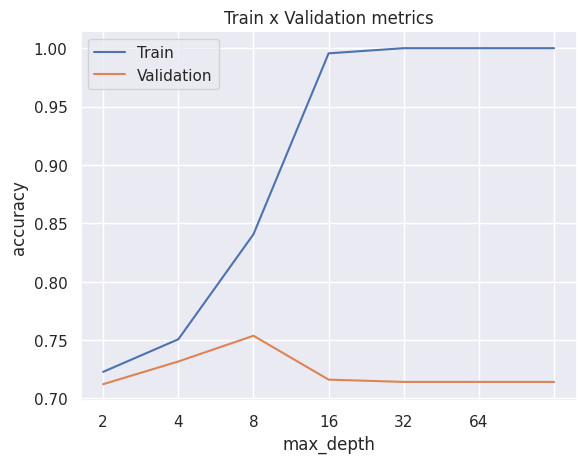

In [38]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = 23).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) 
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [39]:
dt_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 8,
                                             random_state = 23).fit(X_train,y_train)
y_pred_2 = dt_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_2), 2)}")
print(f"Recall: {round(recall_score(y_test,y_pred_2),3)}")
print(f"Precision: {round(precision_score(y_test,y_pred_2), 2)}")
print(f"F1: {round(f1_score(y_test,y_pred_2), 2)}")
print(f"Auc: {round(roc_auc_score(y_test,y_pred_2), 2)}")

Accuracy: 0.78
Recall: 0.703
Precision: 0.76
F1: 0.73
Auc: 0.77


# **Logistic Regression**

In [40]:
lg_model = LogisticRegression(max_iter=500)
lg_model.fit(X_train, y_train)

y_pred_3 = lg_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_3), 2)}")
print(f"Recall: {round(recall_score(y_test,y_pred_3),3)}")
print(f"Precision: {round(precision_score(y_test,y_pred_3), 2)}")
print(f"F1: {round(f1_score(y_test,y_pred_3), 2)}")
print(f"Auc: {round(roc_auc_score(y_test,y_pred_3), 2)}")

Accuracy: 0.72
Recall: 0.661
Precision: 0.68
F1: 0.67
Auc: 0.71


# **XGBClassifier**

In [41]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_4 = xgb_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_4), 2)}")
print(f"Recall: {round(recall_score(y_test,y_pred_4),3)}")
print(f"Precision: {round(precision_score(y_test,y_pred_4), 2)}")
print(f"F1: {round(f1_score(y_test,y_pred_4), 2)}")
print(f"Auc: {round(roc_auc_score(y_test,y_pred_4), 2)}")

Accuracy: 0.79
Recall: 0.754
Precision: 0.76
F1: 0.76
Auc: 0.79


# **CatBoostClassifier**

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from catboost import CatBoostClassifier

ct=CatBoostClassifier(verbose=False)
ct.fit(X_train,y_train)
y_pred_5 = ct.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_5), 2)}")
print(f"Recall: {round(recall_score(y_test,y_pred_5),3)}")
print(f"Precision: {round(precision_score(y_test,y_pred_5), 2)}")
print(f"F1: {round(f1_score(y_test,y_pred_5), 2)}")
print(f"Auc: {round(roc_auc_score(y_test,y_pred_5), 2)}")


Accuracy: 0.8
Recall: 0.72
Precision: 0.79
F1: 0.76
Auc: 0.79


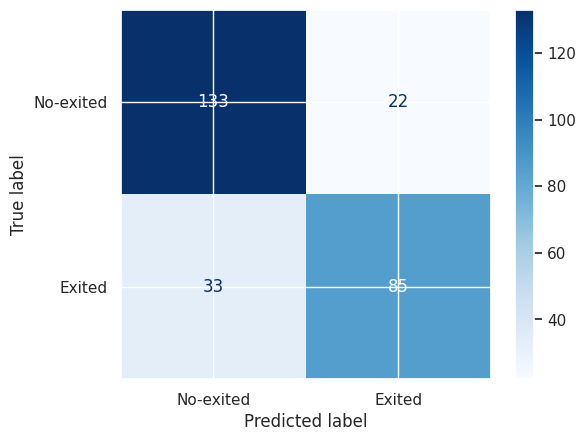

In [43]:
# ConfusionMatrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_5, cmap = plt.cm.Blues, display_labels = ['No-exited', 'Exited'])

In [44]:
print(classification_report(y_test, y_pred_5))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       155
           1       0.79      0.72      0.76       118

    accuracy                           0.80       273
   macro avg       0.80      0.79      0.79       273
weighted avg       0.80      0.80      0.80       273

